# RFM-анализ пользовательской активности

### Ипортируем библиотеки и загрузим данные.
### Для работы с большим датасетом используем Dask

In [55]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
%time
import dask.dataframe as dd
df = dd.read_table('rfm.tsv', sep = '\t', 
                 names = ['timestamp', 'id', 'url', 'geo_id', 'category', 'price'], 
                 dtype={'geo_id': 'object', 'category': 'object'}, encoding = 'latin-1')
# Загрузка данных

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


In [4]:
df.head() # посмотрим как выглядят данные

,timestamp,id,url,geo_id,category,price
0,1380052543,00002ad98ae4290672431d702c211b4a,/_c/YwrVrj_29IVZDmKxglT53wo7Pk8.html,10000,NaN,NaN
1,1375703582,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=y5fc6079b758f5a4e3646a8...,10000,NaN,NaN
2,1374479873,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=yd6558780959d5130b32e1a...,10000,NaN,NaN
3,1374479892,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=yd6558780959d5130b32e1a...,10000,NaN,NaN
4,1374480337,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=yd6558780959d5130b32e1a...,10000,NaN,NaN


Для первичной сегментации пользователей оставим только строки, отвечающие за переход пользователя в магазин (соответсвуют click в графе url и NaN в графе price)

In [5]:
data = df.compute() # переводим данные в pandas df для экономии времени
data = data.dropna() # удаляем ненужные на данный момент строки
data.head()

,timestamp,id,url,geo_id,category,price
64,1363416109,00023fcc5c93cb4674bdad0d448272e6,click,213,2662954,30.0
65,1363154958,00023fcc5c93cb4674bdad0d448272e6,click,213,6427100,10.0
66,1363241850,00023fcc5c93cb4674bdad0d448272e6,click,213,6427100,10.0
67,1363242370,00023fcc5c93cb4674bdad0d448272e6,click,213,6427100,10.0
68,1363165672,00023fcc5c93cb4674bdad0d448272e6,click,213,6427100,80.0


In [6]:
print(len(data['id'])) # посмотрим на объём выборки

363313


Преобразуем графу timestamp так, чтобы получить время, прошедшее с клика пользователя в днях:

In [7]:
data['timestamp'] = (1552840895 - data['timestamp']) / 86400 # учитывая что в сутках 86400 секунд

In [8]:
data = data.drop(labels = 'url', axis = 1) # удалим бесполезный столбец url

In [9]:
data = data.sort_values(by = 'id', axis = 0)

In [51]:
id_tracker = '00023fcc5c93cb4674bdad0d448272e6' # id 1 встречающегося в данных пользователя
latest_click_time = 1552840895
clicks_time = []
frequencies = []
freq = 0
ltvs = []
ltv = 0
user_ids = ['00023fcc5c93cb4674bdad0d448272e6']
for index, row in data.iterrows():
    if(row['id'] == id_tracker):
        ltv += row['price']
        freq +=1
        if(row['timestamp'] < latest_click_time):
            latest_click_time = row['timestamp']
    else:
        user_ids.append(row['id'])
        ltvs.append(ltv)
        ltv = row['price']
        frequencies.append(freq)
        freq = 1
        clicks_time.append(latest_click_time)
        latest_click_time = 1552840895
        id_tracker = row['id']
        if(row['timestamp'] < latest_click_time):
            latest_click_time = row['timestamp']
      

In [11]:
RMF_data = pd.DataFrame(data = np.column_stack([clicks_time, frequencies, ltvs]),
                        columns = ['Recency', 'Frequency', 'Monetary'])

In [12]:
def get_Recency_index(row):
    if row['Recency'] < 1930. : # анализ проводится с учётом того, что данные только взяты из базы
        val = 1
    elif row['Recency'] >= 1930. and row['Recency'] < 1961.:
        val = 2
    elif row['Recency'] >= 1961. and row['Recency'] < 2023.:
        val = 3
    elif row['Recency'] >= 2023. and row['Recency'] < 2086:
        val = 4
    else:
        val = 5
    return val

In [13]:
RMF_data['Recency_types'] = RMF_data.apply(get_Recency_index, axis=1)

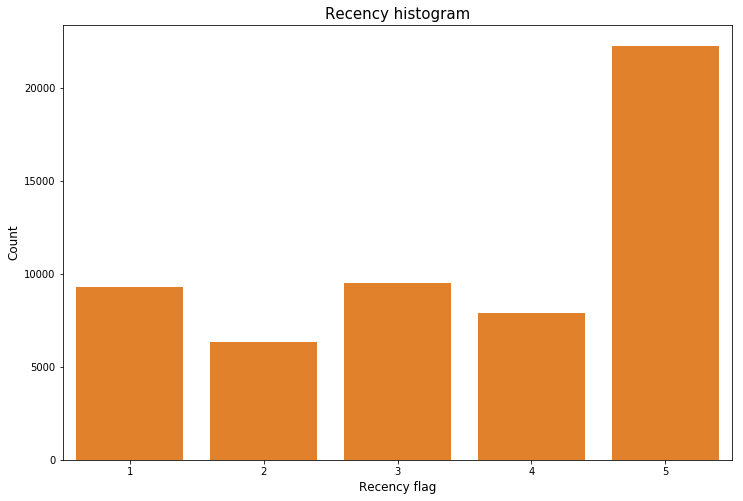

In [14]:
plt.figure(figsize=(12,8))
sns.countplot(x='Recency_types', data=RMF_data, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Recency flag', fontsize=12)
#plt.xticks(rotation='vertical')
plt.title('Recency histogram', fontsize=15)
plt.show()


In [28]:
unique_clicks=RMF_data[['Frequency']].drop_duplicates()
unique_clicks['Frequency_Band'] = pd.qcut(unique_clicks['Frequency'], 5)
unique_clicks=unique_clicks[['Frequency_Band']].drop_duplicates()
unique_clicks

,Frequency_Band
0,"(0.999, 47.8]"
158,"(94.6, 142.4]"
181,"(47.8, 94.6]"
417,"(142.4, 215.6]"
1701,"(215.6, 2356.0]"


In [29]:
def get_Frequency_index(row):
    if row['Frequency'] <= 48:
        val = 5
    elif row['Frequency'] > 48 and row['Frequency'] <= 95:
        val = 4
    elif row['Frequency'] > 95 and row['Frequency'] <= 142:
        val = 3
    elif row['Frequency'] > 142 and row['Frequency'] <= 215:
        val = 2
    else:
        val = 1
    return val

In [30]:
RMF_data['Frequency_types'] = RMF_data.apply(get_Frequency_index, axis=1)

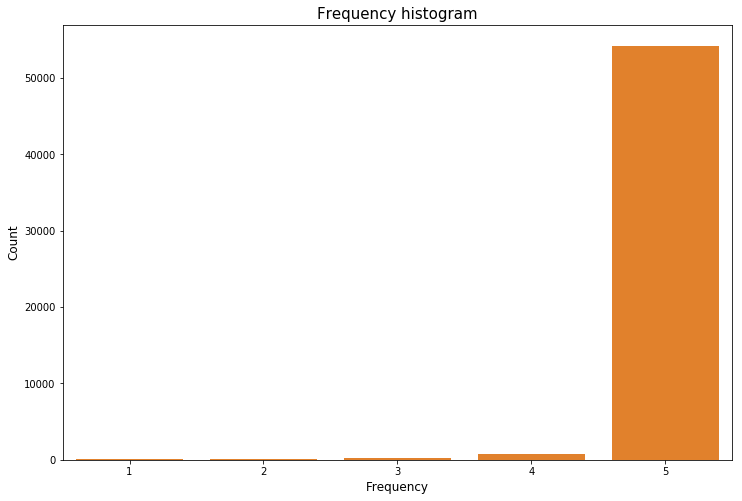

In [31]:
plt.figure(figsize=(12,8))
sns.countplot(x='Frequency_types', data=RMF_data, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Frequency', fontsize=12)
#plt.xticks(rotation='vertical')
plt.title('Frequency histogram', fontsize=15)
plt.show()



Разделение выглядит неинформативным, попробуем изменить границы классов:

In [73]:
def get_Frequency_index_v2(row):
    if row['Frequency'] <= 3:
        val = 5
    elif row['Frequency'] > 3 and row['Frequency'] <= 10:
        val = 4
    elif row['Frequency'] > 10 and row['Frequency'] <= 30:
        val = 3
    elif row['Frequency'] > 30 and row['Frequency'] <= 100:
        val = 2
    else:
        val = 1
    return val

In [74]:
RMF_data['Frequency_types_alternate'] = RMF_data.apply(get_Frequency_index_v2, axis=1)

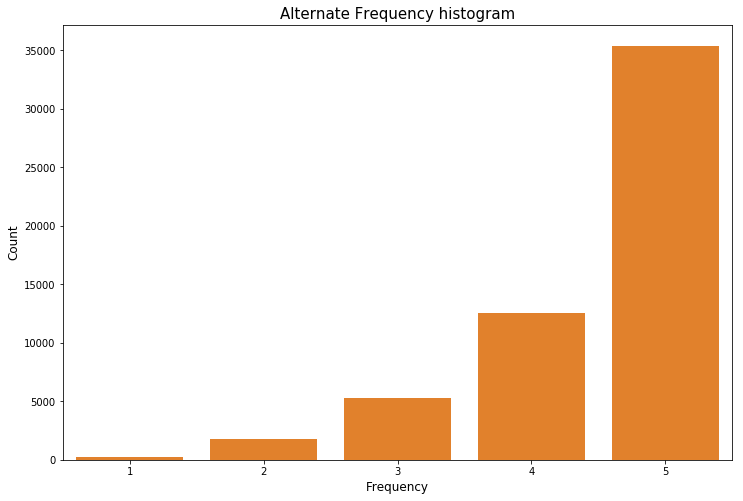

In [77]:
plt.figure(figsize=(12,8))
sns.countplot(x='Frequency_types_alternate', data=RMF_data, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Frequency', fontsize=12)
#plt.xticks(rotation='vertical')
plt.title('Alternate Frequency histogram', fontsize=15)
plt.show()

Такая сегментация позволит лучше понимать, как работать с конкретным пользователем.

In [23]:
unique_price=RMF_data[['Monetary']].drop_duplicates()
unique_price['monetory_Band'] = pd.qcut(RMF_data['Monetary'], 5)
unique_price=unique_price[['monetory_Band']].drop_duplicates()
unique_price

,monetory_Band
0,"(205.0, 37020.0]"
1,"(77.0, 205.0]"
3,"(31.0, 77.0]"
7,"(12.0, 31.0]"
8,"(-0.001, 12.0]"


In [24]:
def get_Monetary_index(row):
    if row['Monetary'] <= 12:
        val = 5
    elif row['Monetary'] > 12 and row['Monetary'] <= 31:
        val = 4
    elif row['Monetary'] > 31 and row['Monetary'] <= 77:
        val = 3
    elif row['Monetary'] > 77 and row['Monetary'] <= 205:
        val = 2
    else:
        val = 1
    return val

In [25]:
RMF_data['Monetary_types'] = RMF_data.apply(get_Monetary_index, axis=1)

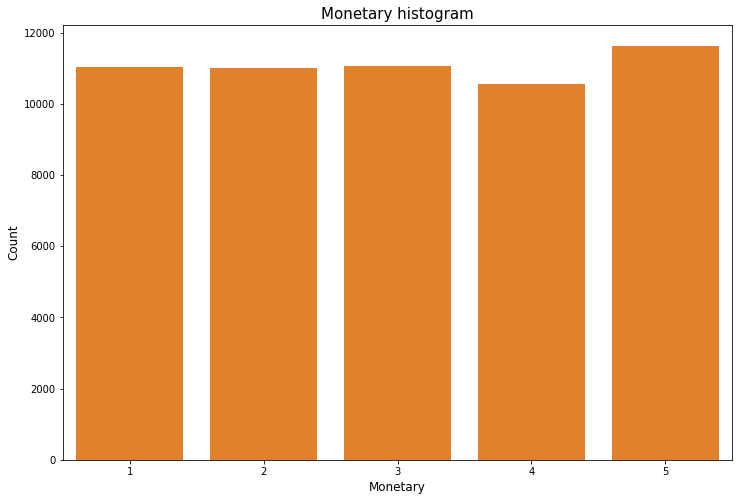

In [26]:
plt.figure(figsize=(12,8))
sns.countplot(x='Monetary_types', data=RMF_data, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Monetary', fontsize=12)
#plt.xticks(rotation='vertical')
plt.title('Monetary histogram', fontsize=15)
plt.show()

In [78]:
RMF_table = RMF_data.drop(labels = ['Recency' , 'Frequency', 'Monetary', 'Frequency_types'], axis = 1)
RMF_table['id'] = pd.Series(user_ids[:-1], index = RMF_table.index)
RMF_table.head()

,Recency_types,Monetary_types,Frequency_types_alternate,id
0,3,1,3,00023fcc5c93cb4674bdad0d448272e6
1,5,2,4,00029bdb868e12bb62b8c574b274dbb7
2,4,2,5,00035d94fcd7e814d56531cf95b81ceb
3,2,3,4,00045ac92fb4ed78bc66c40f52775acd
4,3,2,3,00056ac58d63ef1d4b5fb73324bf845d


### RF - таблица:

In [ ]:
oneoff_buyers = RMF_table.loc()

In [156]:
RMF_data.corr()

,Recency,Frequency,Monetary,Recency_types,Frequency_types,Monetary_types,Frequency_types_alternate
Recency,1.000000,-0.101884,-0.109163,0.924117,0.079444,0.148352,0.160036
Frequency,-0.101884,1.000000,0.789697,-0.107161,-0.776101,-0.307213,-0.566389
Monetary,-0.109163,0.789697,1.000000,-0.110609,-0.669222,-0.375593,-0.523053
Recency_types,0.924117,-0.107161,-0.110609,1.000000,0.085888,0.138872,0.161704
Frequency_types,0.079444,-0.776101,-0.669222,0.085888,1.000000,0.168686,0.422994
Monetary_types,0.148352,-0.307213,-0.375593,0.138872,0.168686,1.000000,0.660088
Frequency_types_alternate,0.160036,-0.566389,-0.523053,0.161704,0.422994,0.660088,1.000000


## Импортируем данные о регионах и категориях товаров:

In [155]:
geo_data = pd.read_csv('geo_table', sep = '\t', header = 0)
geo_data.head(2)

,id,name,parent_region_id,type,TZ_OFFSET
0,1,Москва и Московская область,3.0,5,10800
1,2,Санкт-Петербург,10174.0,6,10800


In [80]:
categories_data = pd.read_csv('categories_tree', sep = '\t', header = 0)
categories_data.head(2)

,id,parent_id,hyper_cat_id,category_name,category_pass
0,984,978,91768,Этикет-пистолеты,\tОборудование\tОборудование для магазинов\tЭт...
1,23187,978,10469630,Рекламные дисплеи и интерактивные панели,\tОборудование\tОборудование для магазинов\tРе...


In [100]:
sorted_geo = sort(geo_data['parent_region_id'])

In [94]:
sort(data['geo_id'])

array(['0', '0', '0', ..., '98623', '98623', '98631'], dtype=object)

In [109]:
reg_list = geo_data['parent_region_id'].unique().astype(int)

In [113]:
reg_list = sorted(reg_list)

In [117]:
len(geo_data['name']

40787

In [118]:
len(reg_list)

6067

In [120]:
reg_list = pd.Series(reg_list)

In [154]:
geo_data.loc[geo_data['id'] == 127499]

,id,name,parent_region_id,type,TZ_OFFSET
51665,127499,Нагольный,99244.0,7,10800


In [147]:
categories_data.loc[categories_data['hyper_cat_id'] == 90829]

,id,parent_id,hyper_cat_id,category_name,category_pass


In [143]:
data.head(100)

,timestamp,id,geo_id,category,price
64,2192.416505,00023fcc5c93cb4674bdad0d448272e6,213,2662954,30.0
88,2242.396632,00023fcc5c93cb4674bdad0d448272e6,213,90984,14.0
87,2242.399097,00023fcc5c93cb4674bdad0d448272e6,213,90976,9.0
86,2238.951238,00023fcc5c93cb4674bdad0d448272e6,213,90976,10.0
84,2177.490671,00023fcc5c93cb4674bdad0d448272e6,213,90829,20.0
83,2242.397188,00023fcc5c93cb4674bdad0d448272e6,213,90829,12.0
82,1970.921042,00023fcc5c93cb4674bdad0d448272e6,213,90783,16.0
81,1970.920648,00023fcc5c93cb4674bdad0d448272e6,213,90783,11.0
80,1975.076424,00023fcc5c93cb4674bdad0d448272e6,213,90783,11.0
79,1975.077396,00023fcc5c93cb4674bdad0d448272e6,213,90783,11.0


In [152]:
geo_data['id'].unique()

array([     1,      2,      3, ..., 127497, 127498, 127499])